<div class="alert alert-success">
<b>Reviewer's comment V2</b>

Thank you for taking the time to improve the project! It is accepted now. Keep up the good work on the next sprint!
    
FYI, I answered your comments about seasonality and train/test set performance below

</div>

**Review**

Hi, my name is Dmitry and I will be reviewing your project.
  
You can find my comments in colored markdown cells:
  
<div class="alert alert-success">
  If everything is done successfully.
</div>
  
<div class="alert alert-warning">
  If I have some (optional) suggestions, or questions to think about, or general comments.
</div>
  
<div class="alert alert-danger">
  If a section requires some corrections. Work can't be accepted with red comments.
</div>
  
Please don't remove my comments, as it will make further review iterations much harder for me.
  
Feel free to reply to my comments or ask questions using the following template:
  
<div class="alert alert-info">
  For your comments and questions.
</div>
  
First of all, thank you for turning in the project! You did a pretty good job overall, but there's one small problem that needs to be fixed before the project can be accepted. I also added some suggestions for imporvements. Let me know if you have any questions!

# Project description

Sweet Lift Taxi company has collected historical data on taxi orders at airports. To attract more drivers during peak hours, we need to predict the amount of taxi orders for the next hour. Build a model for such a prediction.

The RMSE metric on the test set should not be more than 48.

## Project instructions

1. Download the data and resample it by one hour.
2. Analyze the data.
3. Train different models with different hyperparameters. The test sample should be 10% of the initial dataset. 
4. Test the data using the test sample and provide a conclusion.

## Data description

The data is stored in file `taxi.csv`. The number of orders is in the '*num_orders*' column.

## Preparation

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import pyplot

import sklearn.metrics
import sklearn.preprocessing

from sklearn.model_selection import TimeSeriesSplit, train_test_split, GridSearchCV
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV
import lightgbm as lgb
import xgboost as xgb
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

from sklearn.utils import shuffle
from IPython.display import display
from collections import Counter

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


True

None

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


<AxesSubplot:xlabel='datetime'>

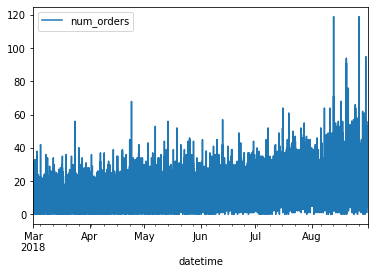

In [2]:
df = pd.read_csv('/datasets/taxi.csv', parse_dates=['datetime'], index_col=[0])
df=df.sort_index()

display(df.index.is_monotonic, #returns true if chronological, 
        df.info(),
       df.head(),
       df.plot())

**Searching for strange values**

In [3]:
(df['num_orders'] < 0).sum().sum() #counting the number of negative values

0

### Initial Dataframe Info

1) The data was loaded successfully.

2) datetime was correctly formated in datetime dtype and was set as the dataframe index.

3) There are no missing values.

4) There are no duplicate rows.

5) The data is relatively small with only 2 columns and 26,496 rows.

6) The data spans 5 months: March - August 2018.

7) The initial graph does not represent anything useful as it is, but it can be further analyzed in the next section.

<div class="alert alert-success">
<b>Reviewer's comment</b>

The data was loaded and initially inspected

</div>

## Analysis

Before we resample the data for 1H intervals, we should understand the general trend of the company

<AxesSubplot:xlabel='datetime'>

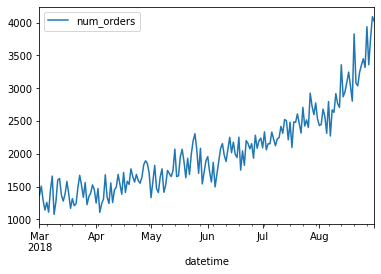

In [4]:
df.resample('1D').sum().plot()

We can see that their order numbers are nearly quadrupled in the past 5 months, which shows some insight as to why they are requesting a model to predict orders by the hour.

**Now, we can analyze the data further by seeing if it is stationary**

<AxesSubplot:xlabel='datetime'>

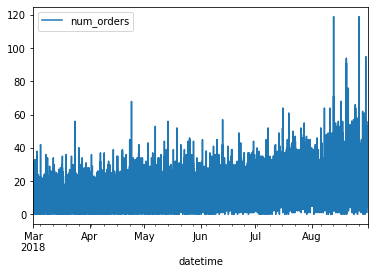

In [5]:
df.plot()

It looks like the data is stationary enough for forcasting

<div class="alert alert-warning">
<b>Reviewer's comment</b>

It would be nice to dive a bit more into the data. For example, you could do a seasonal decomposition to check for a seasonality pattern ([example](https://machinelearningmastery.com/decompose-time-series-data-trend-seasonality/))

</div>

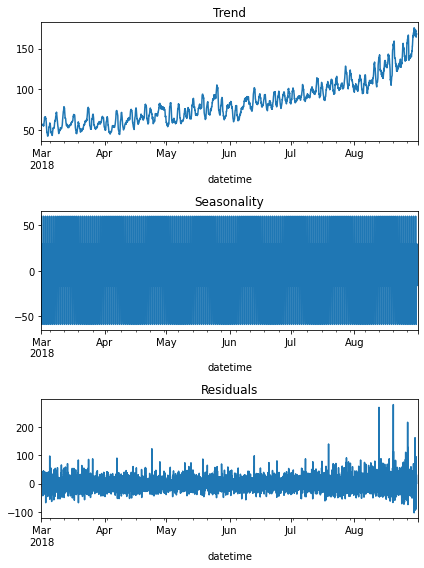

In [6]:
df = df.resample('1H').sum() 

decomposed = seasonal_decompose(df, period=24)
plt.figure(figsize=(6, 8))
plt.subplot(311)
# To display the graph correctly, specify its
# axes ax equal to plt.gca() (gca = get current axis)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

<div class="alert alert-info">
<b>Student's comment V2</b>  
    I tried making the seasonal decomposition, but was unable to replicate the 24-hour window that you mention in your other comment. I tried using the period arguement, which lets me at least plot the graph without errors, but I don't know what value to use for it.
</div>

<div class="alert alert-warning">
<b>Reviewer's comment V2</b>

Yeah, the plot seems too busy to discern anything! But we can just look at a smaller slice of the decomposed data (I added an example below). Seasonality is periodic by definition, so any other slice of the same length will look the same (up to moving the starting point).
    

</div>

<AxesSubplot:xlabel='datetime'>

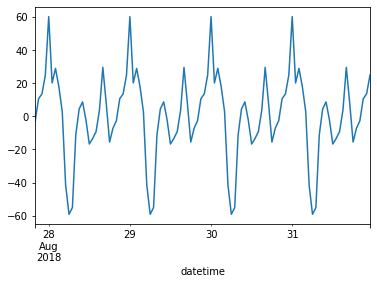

In [9]:
decomposed.seasonal[-100:].plot()

The following cell is to be used if time series difference was necessary

In [7]:
#ts_diff = time series difference

#ts_diff = df.resample('1H').sum()
#ts_diff -= ts_diff.shift()
#ts_diff['mean'] = ts_diff['num_orders'].rolling(15).mean()
#ts_diff['std'] = ts_diff['num_orders'].rolling(15).std()
#ts_diff.plot()

**If we are going to predict order numbers by the hour, we will want to:**

**1)** Resample to the data to 1H intervals

**2)** Split the data into train and test

In [8]:
train, test = train_test_split(df, shuffle=False, test_size=0.2) #4:1 ratio

#ensuring the split worked
print(train.index.min(), train.index.max())
print(test.index.min(), test.index.max())

2018-03-01 00:00:00 2018-07-26 03:00:00
2018-07-26 04:00:00 2018-08-31 23:00:00


<div class="alert alert-success">
<b>Reviewer's comment</b>

The data was resampled correctly. The split into train and test is done without shuffling

</div>

**Next, we can measure the accuracy of the time series forecasting/model sanity check**

In [9]:
print('Number of Orders:', test['num_orders'].median())

pred_previous = test['num_orders'].shift(fill_value=train['num_orders'].iloc[-1])


print('MAE:', mean_absolute_error(test, pred_previous))
print('RMSE:', mean_squared_error(test, pred_previous)**0.5)

Number of Orders: 120.0
MAE: 40.671945701357465
RMSE: 53.36807644753937


<div class="alert alert-success">
<b>Reviewer's comment</b>

Using previous values is a nice simple baseline!

</div>

<div class="alert alert-info">
<b>Student's comment V1</b>  
    This MAE is a 30% error, which is higher compared with the theory section's MAE 
    (13%). I'm unsure if this is still a small enough percentage to be considered acceptable.
</div>

<div class="alert alert-warning">
<b>Reviewer's comment</b>

Not sure what you mean by 'theory section's MAE'. Could you elaborate on that?

</div>

**Now, we can make lag and rolling mean features**

In [10]:
#lag features exclude current value
#using lag features is also called the "sliding window" method. The predetermined size of the 
#window (rolling_mean) will move across the data and compute the mean

def make_features(df, max_lag, rolling_mean_size):
    df['year'] = df.index.year
    df['month'] = df.index.month
    df['day'] = df.index.day
    df['dayofweek'] = df.index.dayofweek

    for lag in range(1, max_lag + 1): 
        df['lag_{}'.format(lag)] = df['num_orders'].shift(lag)

    df['rolling_mean'] = (
        df['num_orders'].shift().rolling(rolling_mean_size).mean()
    )


make_features(df, 24, 10)

df.head(20)

,num_orders,year,month,day,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,...,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,2018,3,1,3,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,2018,3,1,3,124.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,2018,3,1,3,85.0,124.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,2018,3,1,3,71.0,85.0,124.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,2018,3,1,3,66.0,71.0,85.0,124.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 05:00:00,6,2018,3,1,3,43.0,66.0,71.0,85.0,124.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 06:00:00,12,2018,3,1,3,6.0,43.0,66.0,71.0,85.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 07:00:00,15,2018,3,1,3,12.0,6.0,43.0,66.0,71.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 08:00:00,34,2018,3,1,3,15.0,12.0,6.0,43.0,66.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<div class="alert alert-warning">
<b>Reviewer's comment</b>

Feature engineering looks good, although I would suggest using more lag features (if you check the seasonal decomposition, there seems to be a nice 24-hour pattern, so it would make sense to use at least 24 lags). Also, as we're doing hourly predictions adding an 'hour' feature would make sense. On the other hand 'year` is not very useful, as we only have data for 2018

</div>

### Analysis Conclusion

1) The data was stationary enough to disregard the usage of time series difference

2) A model sanity check was performed which produced a 30% error when compared with the median 

3) The sliding window method was used to create the rolling mean feature

## Training

**First, we must split the data and drop the missing values in the train set**

In [11]:
train, test = train_test_split(df, shuffle=False, test_size=0.2)
train=train.dropna()

print(train.shape)
print(test.shape)

(3508, 30)
(884, 30)


<div class="alert alert-success">
<b>Reviewer's comment</b>

Ok!

</div>

**Next, create the forecasting variables**

In [12]:
X_train = train.drop(columns=['num_orders'])
X_test = test.drop(columns=['num_orders'])
y_train = train['num_orders']
y_test = test['num_orders'] 


<div class="alert alert-success">
<b>Reviewer's comment</b>

Correct!

</div>

**Linear Regression Training**

In [13]:
model_lr = LinearRegression()
model_lr.fit(X_train, y_train)
pred1_lr = model_lr.predict(X_train)
pred2_lr = model_lr.predict(X_test) 

print("RMSE for the training set:", mean_squared_error(pred1_lr, y_train)**0.5)
#print("RMSE for the test set: ", mean_squared_error(pred2_lr, y_test)**0.5)

RMSE for the training set: 24.614213570629374


**Random Forest Regression Training**

In [14]:
model_rfr = RandomForestRegressor(random_state=12345, n_estimators=5)
model_rfr.fit(X_train, y_train)
pred1_rfr = model_rfr.predict(X_train)
pred2_rfr = model_rfr.predict(X_test) 

print("RMSE for the training set:", mean_squared_error(pred1_rfr, y_train)**0.5)

RMSE for the training set: 11.343979561507691


**LightGBM Training**

In [15]:
model_lgb = lgb.LGBMRegressor(learning_rate=0.1, n_estimators=50, random_state=42)
model_lgb.fit(X_train, y_train) #no cat_features to specify
pred1_lgb = model_lgb.predict(X_train)
pred2_lgb = model_lgb.predict(X_test)

print("RMSE for the training set:", mean_squared_error(pred1_lgb, y_train)**0.5)

RMSE for the training set: 14.868300422318898


**XGBoost Training**

In [16]:
#model_xgb = xgb.XGBRegressor(n_estimators=100, max_depth=3)
#model_xgb.fit(X_train, y_train)
#pred1_xgb = model_xgb.predict(X_train)
#pred2_xgb = model_xgb.predict(X_test)

#print("RMSE for the training set:", mean_squared_error(pred1_xgb, y_train)**0.5)

In [17]:
model_xgb = xgb.XGBRegressor()
param_search = {'max_depth' : [3, 5]}

tscv = TimeSeriesSplit(n_splits=5)
grid = GridSearchCV(estimator=model_xgb, cv=tscv,
                        param_grid=param_search)
grid.fit(X_train, y_train)
pred1_xgb = grid.predict(X_train)

#print best parameter after tuning 
print("RMSE for the training set:", mean_squared_error(pred1_xgb, y_train)**0.5)
print(grid.best_params_) 


RMSE for the training set: 16.02864960649008
{'max_depth': 3}


In [18]:
#fitting best XGB model
model_xgb = xgb.XGBRegressor(max_depth=3)
model_xgb.fit(X_train, y_train)
pred2_xgb = model_xgb.predict(X_test)

### Training Conclusion:

1) The model with the best/lowest training RMSE score was random forest regressor at 13 

2) The model with the worst/highest training RMSE score was Linear Regression at 29

3) All training scores surpassed the sanity check value (53 RMSE)

## Testing

In [19]:
testing = pd.DataFrame()

testing['model'] = ['Linear Regression', 'Random Forest Regression', 'LightGBM', 'XGBoost']

testing['RMSE'] = [mean_squared_error(pred2_lr, y_test)**0.5, 
                   mean_squared_error(pred2_rfr, y_test)**0.5,
                  mean_squared_error(pred2_lgb, y_test)**0.5,
                  mean_squared_error(pred2_xgb, y_test)**0.5]

testing

,model,RMSE
0,Linear Regression,40.540767
1,Random Forest Regression,47.010053
2,LightGBM,45.131054
3,XGBoost,43.854186


<div class="alert alert-info">
  The LR model had the worst training RMSE but the best testing RMSE, which seems a little suspicious to me.
</div>

<div class="alert alert-warning">
<b>Reviewer's comment</b>

> The LR model had the worst training RMSE but the best testing RMSE, which seems a little suspicious to me.
    
Why is that suspicious? Comparing models based on their train set performance doesn't make much sense: what we'd like is for our models to generalize to new data, not memorize the training set. And evaluating a model on the train set tells us nothing about how well it generalizes to new data.

</div>

<div class="alert alert-info">
  Since the train RMSE was not great, I was expecting the test RMSE to also perform badly. So when it turned out to be the best performing one for the test set, I was surprised.
</div>

<div class="alert alert-warning">
<b>Reviewer's comment V2</b>

Well, it just means that the other models [overfitted](https://en.wikipedia.org/wiki/Overfitting) more. In any case, the train set performance is a poor indicator of test set performance.

</div>

<div class="alert alert-danger">
<s><b>Reviewer's comment</b>

Great, you tried a couple of different models and one of them beats the required RMSE threshold. Could you please add some hyperparameter tuning for at least one model? Remember that for hyperparameter tuning we either need a separate validation set, or we can do cross-validation on the train set (using an appropriate cross-validation scheme for time series like [TimeSeriesSplit](https://scikit-learn.org/stable/modules/cross_validation.html#time-series-split), an object of TimeSeriesSplit class can be passed as the 'cv' parameter to GridSearchCV, cross_val_score, etc)
    


</div>

<div class="alert alert-success">
<b>Reviewer's comment V2</b>

Very good!
    

</div>

### Testing Conclusion:

1) The model with the lowest RMSE score was the Linear Regression model, which is what I recommend the company uses to predict order numbers for the next hour.

# Review checklist

- [x]  Jupyter Notebook is open
- [ ]  The code is error-free
- [ ]  The cells with the code have been arranged in order of execution
- [ ]  The data has been downloaded and prepared
- [ ]  The data has been analyzed
- [ ]  The model has been trained and hyperparameters have been selected
- [ ]  The models have been evaluated. Conclusion has been provided
- [ ] *RMSE* for the test set is not more than 48